2D Bi-Gaussian Mixture Model (GMM) is expected to have better performance compared to Principal Component Analysis, due to the physical nature of the process.

Here, we predict NCOMP=10 or 12 parameters which generates Bi-Gaussian distribution on the LPS image, rather than the full image.

In [ ]:
# Autoload when refreshing notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('../../')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, extractDAQNonBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN, extract_processed_images, apply_centroid_correction,apply_tcav_zeroing_filter, MLP
from Python_Functions.gmm import biGaussian_image_from_flattened_params, flatten_biGaussian_params, unflatten_biGaussian_params, gaussian_2d_pdf, image_to_bigaussian_params, is_valid_biGaussian_params, GeometricScaler

/home/truewis/FACET-II-ML-diag/notebooks/workflow_walkthroughs/../../Python_Functions/functions.py:527: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if peaks.size is not 2:


### Load Preprocessed Images

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from scipy.io import loadmat 
import re
import os 
import joblib
# Assumed: commonIndexFromSteps, extractDAQBSAScalars, and other helper functions are available
# ----------------------------------------------------------------------
# 0. Load the model with joblib

model_to_load = '../../model/LPS/MLP_LPS_GMM_Forest_E338_12710_20251217_115134.pkl'  # Modify as needed
model = joblib.load(model_to_load)

# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# 1. Define the list of (experiment, runname, step_identifier) pairs to load
# ----------------------------------------------------------------------
run_pairs = [
    ('E338', '12691', 1),  # Example pairs, modify this list
    #('E300', '12431', 1),
    # Add more pairs here...
]

# ----------------------------------------------------------------------
# 2. Initialize lists for concatenation
# ----------------------------------------------------------------------
all_images = []
all_predictors = []
all_indices = []

print("Starting multi-run data loading and concatenation...")

# ----------------------------------------------------------------------
# 3. Loop through runs, load data, and concatenate
# ----------------------------------------------------------------------
for experiment, runname, step_id in run_pairs:
    
    # --- A. Load Processed LPSImage Data and Good Shots Index ---
    pickle_filename = f'../../data/processed/LPSImage_goodshots_{experiment}_{runname}_{step_id}.pkl'

    try:
        with open(pickle_filename, 'rb') as f:
            data = pickle.load(f)
        
        LPSImage_good = data['LPSImage'] # Filtered LPS images
        # This 'goodShots' index is relative to the phase-filtered data (all_idx).
        goodShots_scal_common_index = data['scalarCommonIndex'] 
        
        print(f"Loaded {experiment}_{runname}: LPSImage shape {LPSImage_good.shape}")
        
    except FileNotFoundError:
        print(f"Skipping {experiment}_{runname}: Pickle file not found at {pickle_filename}")
        continue
    
    # --- B. Load and Filter Predictor Data (BSA Scalars) ---
    
    # 1. Load data_struct
    dataloc = f'../../data/raw/{experiment}/{experiment}_{runname}/{experiment}_{runname}.mat'
    try:
        mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
        data_struct = mat['data_struct']
    except FileNotFoundError:
        print(f"Skipping {experiment}_{runname}: .mat file not found at {dataloc}")
        continue

    # 2. Extract full BSA scalars (filtered by step_list if needed)
    # Don't filter by common index here, we'll do it with the goodShots scalar common index loaded from the file
    bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct, filter_index=False)
    bsaScalarData = apply_tcav_zeroing_filter(bsaScalarData, bsaVars)
    # 3. Extract non BSA scalars the same way
    nonBsaScalarData, nonBsaVars = extractDAQNonBSAScalars(data_struct, filter_index=False, debug=False, s20=True)
    nonBsaScalarData = apply_tcav_zeroing_filter(nonBsaScalarData, nonBsaVars)

    # 4. Combine BSA and non-BSA scalar data
    bsaScalarData = np.vstack((bsaScalarData, nonBsaScalarData))
    bsaVars = bsaVars + nonBsaVars

    # 5. Filter BSA data using the final index
    # goodShots_scal_common_index is 1 based indexing from MATLAB, convert to 0 based
    bsaScalarData_filtered = bsaScalarData[:, goodShots_scal_common_index - 1]
    
    # 6. Construct the predictor array
    predictor_current = np.vstack(bsaScalarData_filtered).T
    
    # C. Append to master lists
    all_images.append(LPSImage_good)
    all_predictors.append(predictor_current)
    
# ----------------------------------------------------------------------
# 4. Concatenate and finalize arrays
# ----------------------------------------------------------------------

# Set image half dimensions (should match preprocessing)
yrange = 50
xrange = 150
# Combine all data arrays from the runs
images_tmp = np.concatenate(all_images, axis=0)
images_tmp = images_tmp.reshape(images_tmp.shape[0], 2*yrange, 2* xrange)  # Reshape to (N, height, width)
predictor_tmp = np.concatenate(all_predictors, axis=0)


print("\n--- Final Concatenated Data Shapes ---")
print(f"Total LPS Images (images): {images_tmp.shape}")
print(f"Total Predictors (predictor): {predictor_tmp.shape}")


Starting multi-run data loading and concatenation...
Loaded E338_12691: LPSImage shape (668, 30000)
Applying filter: Setting 705 samples of TCAV_LI20_2400_P to 0 where TCAV_LI20_2400_A < 1.0

--- Final Concatenated Data Shapes ---
Total LPS Images (images): (668, 100, 300)
Total Predictors (predictor): (668, 130)


### XTCAV Phase Check

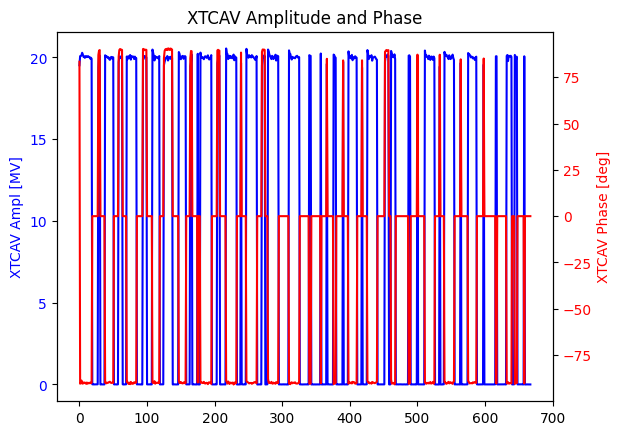

In [3]:
ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = predictor_tmp[:, ampl_idx]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = predictor_tmp[:, phase_idx]
xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

near_minus_90_idx = np.where((xtcavPhase >= -90.55) & (xtcavPhase <= -89.55))[0]
near_plus_90_idx = np.where((xtcavPhase >= 89.55) & (xtcavPhase <= 90.55))[0]
lps_idx = near_minus_90_idx.tolist() + near_plus_90_idx.tolist()
# Flip image horizontally for -90 deg phase
images_flipped = images_tmp.copy()
images_flipped[near_minus_90_idx, :, :] = np.flip(images_tmp[near_minus_90_idx, :, :], axis=2)

fig, ax1 = plt.subplots()
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('XTCAV Amplitude and Phase')
plt.show()

### Calibration

In [4]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
if isChargePV:
    # Extract charge data
    pvidx = [i for i, val in enumerate(isChargePV) if val]
    charge = bsaScalarData[pvidx, :][0] * 1.6e-19  # in C 
    charge_filtered = charge[goodShots_scal_common_index - 1][lps_idx]

# Set flag for current profile fitting. If True, the current profile will be used to refine the GMM fit.
do_current_profile = True
NCOMP = 10

### Exclude BSA Variables

In [5]:
from Python_Functions.functions import exclude_bsa_vars
excluded_var_idx = exclude_bsa_vars(bsaVars)
predictor_tmp_cleaned = np.delete(predictor_tmp, excluded_var_idx, axis=1)[lps_idx, :]
print(f"Predictor shape after excluding variables: {predictor_tmp_cleaned.shape}")

LPSimg = images_flipped[lps_idx]
print(f"LPS Image shape after filtering: {LPSimg.shape}")


Excluding BSA Variables: ['TCAV_LI20_2400_A', 'TCAV_LI20_2400_P', 'TORO_LI20_3163_TMIT', 'TORO_LI20_3255_TMIT', 'BPMS_LI20_3156_X', 'BPMS_LI20_3156_Y', 'BPMS_LI20_3156_TMIT', 'BPMS_LI20_3218_X', 'BPMS_LI20_3218_Y', 'BPMS_LI20_3218_TMIT', 'BPMS_LI20_3265_X', 'BPMS_LI20_3265_Y', 'BPMS_LI20_3265_TMIT', 'BPMS_LI20_3315_X', 'BPMS_LI20_3315_Y', 'BPMS_LI20_3315_TMIT', 'PMT_LI20_3179_QDCRAW', 'PMT_LI20_3350_QDCRAW', 'PMT_LI20_3360_QDCRAW', 'WIRE_LI20_3179_POSN']
Excluded variable indices: [104, 105, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 129]
Predictor shape after excluding variables: (243, 110)
LPS Image shape after filtering: (243, 100, 300)


### Bi-Gaussian Fit

In [6]:
from ipywidgets import interact
def interactive_biGaussian_fit_example(idx):
    biGaussianTest = image_to_bigaussian_params(LPSimg[idx].reshape((2*yrange, 2*xrange)), do_current_profile)
    print("Bi-Gaussian Parameters for Test Image:", biGaussianTest)
    generated_image = gaussian_2d_pdf(biGaussianTest['mu'].numpy()[0], biGaussianTest['Sigma'].numpy()[0]).reshape((2*yrange, 2*xrange)) * biGaussianTest['pi'].numpy()[0] + \
    gaussian_2d_pdf(biGaussianTest['mu'].numpy()[1], biGaussianTest['Sigma'].numpy()[1]).reshape((2*yrange, 2*xrange)) * biGaussianTest['pi'].numpy()[1]
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(LPSimg[idx].reshape((2*yrange, 2*xrange)), cmap='hot', origin='lower')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title("Generated from Bi-Gaussian Fit")
    plt.imshow(generated_image.T, cmap='hot', origin='lower')
    plt.colorbar()
    plt.show()
interact(interactive_biGaussian_fit_example, idx=(0, LPSimg.shape[0]-1, 1))

interactive(children=(IntSlider(value=121, description='idx', max=242), Output()), _dom_classes=('widget-inter…

<function __main__.interactive_biGaussian_fit_example(idx)>

In [10]:
# Convert all images to bi-Gaussian parameters
biGaussian_params_list = []
print(LPSimg.shape)
success_count = 0
for i in range(LPSimg.shape[0]):
    try:
        biGaussian_params = image_to_bigaussian_params(LPSimg[i].reshape((2*yrange, 2*xrange)), do_current_profile, debug=False)
        #print(f"Processed image {i+1}/{images.shape[0]}: Bi-Gaussian params: {biGaussian_params}")
        flattened_params = flatten_biGaussian_params(biGaussian_params)
        biGaussian_params_list.append(flattened_params)
        success_count += 1
    except Exception as e:
        print(f"Error processing image {i}: {e}")
        flattened_params = np.full((NCOMP,), np.nan)  # Assuming 10 parameters for 2-component bi-Gaussian
        biGaussian_params_list.append(flattened_params)

biGaussian_params_array = np.array(biGaussian_params_list)
print("Converted all images to Bi-Gaussian parameters with shape:", biGaussian_params_array.shape)
print(f"Successfully processed {success_count}/{LPSimg.shape[0]} images into Bi-Gaussian parameters.")
# Pickle and save the bi-Gaussian parameters for future use
import time
timestamp = time.strftime("%Y%m%d_%H%M%S")
output_pickle_filename = f'../../data/processed/LPSImage_biGaussian_params_{experiment}_{runname}_{timestamp}.pkl'
with open(output_pickle_filename, 'wb') as f:
    pickle.dump({'biGaussian_params': biGaussian_params_array}, f)
print(f"Saved Bi-Gaussian parameters to {output_pickle_filename}")

(243, 100, 300)
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. 

/home/truewis/FACET-II-ML-diag/notebooks/workflow_walkthroughs/../../Python_Functions/gmm.py:421: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_x, _ = curve_fit(gaussian_1d, x_coords, current_profile, p0=p0_x, maxfev=5000)


Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining origin

### Random Forest Regression

In [11]:

# Filter rows with NaN or invalid bi-Gaussian parameters
valid_rows = [ is_valid_biGaussian_params(biGaussian_params_array[i], do_current_profile) for i in range(biGaussian_params_array.shape[0]) ]
predictor_filtered = predictor_tmp_cleaned[valid_rows]
biGaussian_params_array_filtered = biGaussian_params_array[valid_rows]
print(f"After removing invalid rows, dataset shape: Predictors {predictor_filtered.shape}, Bi-Gaussian Params {biGaussian_params_array_filtered.shape}")

# --- Original scaling and splitting logic follows ---

x_scaler = MinMaxScaler()
iz_scaler = GeometricScaler(xrange, yrange)
x_scaled = x_scaler.fit_transform(predictor_filtered)
Iz_scaled = iz_scaler.fit_transform(biGaussian_params_array_filtered)
x_test_scaled = x_scaled
Iz_test_scaled = Iz_scaled
ntest = np.arange(x_test_scaled.shape[0])

# Convert to PyTorch tensors
X_test = torch.tensor(x_scaled, dtype=torch.float32)
Y_test = torch.tensor(Iz_scaled, dtype=torch.float32)


After removing invalid rows, dataset shape: Predictors (238, 110), Bi-Gaussian Params (238, 10)


In [12]:
# Evaluate model
pred_test_scaled = model.predict(X_test)

# Inverse transform predictions
pred_test_full = iz_scaler.inverse_transform(pred_test_scaled)

Iz_test_true = iz_scaler.inverse_transform(Iz_scaled)

# Compute R² score
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

# Compute R² on scaled data, instead of the actual bi-Gaussian parameters, to avoid distortion from different scales
print("Test R²: {:.2f} %".format(r2_score(Iz_test_scaled.ravel(), pred_test_scaled.ravel()) * 100))

# Plot histogram of R² values for each test sample
r2_values = [r2_score(Iz_test_scaled.T.reshape(NCOMP,Iz_test_scaled.shape[0])[:,i], pred_test_scaled.T.reshape(NCOMP,Iz_test_scaled.shape[0])[:,i]) for i in range(Iz_test_scaled.shape[0])]
# Throw away values outside 0 to 1, and count the number of throws
r2_values_new = [r2 for r2 in r2_values if 0 <= r2 <= 1]
num_throws = len(r2_values) - len(r2_values_new)
plt.figure(figsize=(8, 5))
plt.hist(r2_values_new, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of R² Values for Test Samples')
plt.xlabel('R² Value')
plt.ylabel(f'Plotted Samples: {len(r2_values) - num_throws} / Total Samples: {len(r2_values)}')
plt.show()

ValueError: X has 110 features, but RandomForestRegressor is expecting 444 features as input.

### Plot true vs prediction

In [ ]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image_pred(idx):
    FACTOR = 1e15  # to convert s to fs
    fig, (ax0, ax1, ax2, cx1) = plt.subplots(1,4,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1, 1, 0.02]})

    raw_im = LPSimg[valid_rows][ntest[idx]]
    im0 = ax0.imshow(raw_im, cmap = "jet",aspect='auto',extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))
    ax0.set(ylabel="Energy [pix]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {ntest[idx]})")


    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = biGaussian_image_from_flattened_params(true_params, total_charge=charge_filtered[ntest[idx]], xrange=xrange, yrange=yrange).T
    im1 = ax1.imshow(true_im*FACTOR, cmap = "jet",aspect='auto',extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))

    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="Energy [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")
    # print("True Gaussian Parameters:")
    # true_ug = unflatten_biGaussian_params(true_params)
    # print("Means (Mu):", true_ug['mu'].numpy())
    # print("Covariances (Sigma):", true_ug['Sigma'].numpy())
    # print("Weights (Pi):", true_ug['pi'].numpy())


    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = biGaussian_image_from_flattened_params(pred_params, total_charge=charge_filtered[ntest[idx]], xrange=xrange, yrange=yrange).T
    im2 = ax2.imshow(pred_im*FACTOR, cmap = "jet",aspect='auto', extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "Energy [pix]")
    ax2.set(title = "Prediction")

    print("Predicted Gaussian Parameters:")
    pred_ug = unflatten_biGaussian_params(pred_params)
    print("Means (Mu):", pred_ug['mu'].numpy())
    print("Covariances (Sigma):", pred_ug['Sigma'].numpy())
    print("Weights (Pi):", pred_ug['pi'].numpy())

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    cbar.set_label("Current [A per pixel]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# Create slider
interact(plot_xtcav_image_pred, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0))

In [ ]:
from ipywidgets import interact, IntSlider, Layout
def plot_xtcav_image_pred_current(idx):
    FACTOR = 1e15
    fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10, 6))

    x_grid = np.linspace(-xrange*xtcalibrationfactor*FACTOR, xrange*xtcalibrationfactor*FACTOR, xrange * 2)
    raw_im = np.flip(LPSimg[valid_rows][ntest[idx]], axis=0)
    raw_im_proj = np.sum(raw_im, axis = 0)
    print(raw_im_proj.shape)
    raw_im_proj = raw_im_proj / np.sum(raw_im_proj)
    # Measure the peak for translation
    peak_index = np.argmax(raw_im_proj)
    if isChargePV:
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        raw_im_proj = raw_im_proj * charge_value * FACTOR
    ax0.plot(x_grid, raw_im_proj, label = "raw")
    ax0.set(ylabel="Current [A]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {ntest[idx]}) (Total Charge: {charge_value*1e12:.2f} pC)" if isChargePV else f"Raw Image (Shot Number: {ntest[idx]})")

    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    
    if isChargePV:
        # Normalize true image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        true_im = biGaussian_image_from_flattened_params(true_params, charge_value, xrange=xrange, yrange=yrange)
    else:
        true_im = biGaussian_image_from_flattened_params(true_params, xrange=xrange, yrange=yrange)
    true_im = true_im.T
    true_im_proj = np.sum(true_im, axis = 0)  * FACTOR
    ax0.plot(x_grid+(peak_index-xrange) * xtcalibrationfactor * FACTOR, true_im_proj, label = "fit")


    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    # Current profile is relative to zeta; transpose so that the drive bunch center agrees with the fit.
    pred_params_uf = unflatten_biGaussian_params(pred_params)
    true_params_uf = unflatten_biGaussian_params(true_params)
    pred_params_uf['mu'] -= pred_params_uf['mu'][0] - true_params_uf['mu'][0]
    pred_params = flatten_biGaussian_params(pred_params_uf)
    
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im = biGaussian_image_from_flattened_params(pred_params, charge_value, xrange=xrange, yrange=yrange)
    else:
        pred_im = biGaussian_image_from_flattened_params(pred_params, xrange=xrange, yrange=yrange)
    pred_im = pred_im.T
    pred_im_proj = np.sum(pred_im, axis = 0) * FACTOR
    ax0.plot(x_grid+(peak_index-xrange) * xtcalibrationfactor * FACTOR, pred_im_proj, label = "prediction")
    # Fix x-axis limits
    ax0.set(xlim = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR))
    # Log scale y-axis
    ax0.set(yscale='log')
    ax0.set(ylim=(1e2, None))
    ax0.legend()

    ax1.imshow(np.flip(raw_im, axis=0), cmap = "jet",aspect='auto', extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))

    print("Predicted Gaussian Parameters:")
    pred_ug = unflatten_biGaussian_params(pred_params)
    print("Means (Mu):", pred_ug['mu'].numpy())
    ax1.axvline((true_params_uf['mu'].numpy()[1][0]+peak_index - xrange)*xtcalibrationfactor*FACTOR, color='red', linestyle='--', label='True Mu')#
    ax1.axvline((pred_ug['mu'].numpy()[1][0]+peak_index - xrange)*xtcalibrationfactor*FACTOR, color='green', linestyle='--', label='Predicted Mu')#
    print("Covariances (Sigma):", pred_ug['Sigma'].numpy())
    print("Weights (Pi):", pred_ug['pi'].numpy())
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

    # Display image_to_bigaussian_params debug info
    #biGaussianTest = image_to_bigaussian_params(images[valid_rows][ntest[idx]].reshape((2*yrange, 2*xrange)), do_current_profile, debug=True)
    #print("Bi-Gaussian Parameters for Test Image:", biGaussianTest)
    

# Create slider
interact(plot_xtcav_image_pred_current, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0, layout=Layout(width='80%')))

In [ ]:
print(pred_test_full.shape[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize storage for projected predictions
all_projected_preds = []
all_projected_trues = []
all_projected_raws = []
true_mu_diffs = []
true_mu_a_x = []
pred_mu_diffs = []
pred_mu_a_x = []

# 2. Loop through all indices, predict, and project
for idx in range(pred_test_full.shape[0]):
    # Reshape the predicted parameters for the current shot
    # Assuming pred_test_full is (N_shots, N_params) and parameters are flattened
    pred_params = pred_test_full[idx, :]
    
    # Generate the predicted image from the Gaussian fit
    pred_im = biGaussian_image_from_flattened_params(pred_params, total_charge=charge_filtered[valid_rows][ntest[idx]], xrange=xrange, yrange=yrange)
    
    pred_ug = unflatten_biGaussian_params(pred_params)
    mu_a_pred = pred_ug['mu'][0][0]  # The first component's horizontal mean (mu_A_x)
    mu_b_pred = pred_ug['mu'][1][0]  # The second

    pred_mu_diffs.append(mu_b_pred - mu_a_pred)
    pred_mu_a_x.append(mu_a_pred)
    
    # Get the true Gaussian parameters for sorting/translation
    true_params = Iz_test_true[idx, :]
    true_ug = unflatten_biGaussian_params(true_params)
    
    mu_a = true_ug['mu'][0][0]  # The first component's horizontal mean (mu_A_x)
    mu_b = true_ug['mu'][1][0]  # The second component's horizontal mean (mu_B_x)
    
    true_mu_diffs.append(mu_b - mu_a)
    true_mu_a_x.append(mu_a)


    true_im = biGaussian_image_from_flattened_params(true_params, total_charge=charge_filtered[valid_rows][ntest[idx]], xrange=xrange, yrange=yrange)

    raw_im = LPSimg[valid_rows][ntest[idx]]
    # Take the horizontal projection (sum along the y-axis, axis 0)
    # This results in a 1D array of shape (2*xrange,)
    horizontal_projection = np.sum(pred_im, axis=1)
    horizontal_projection_true = np.sum(true_im, axis=1)
    horizontal_projection_raw = np.sum(raw_im, axis=0)
    all_projected_preds.append(horizontal_projection)
    all_projected_trues.append(horizontal_projection_true)
    all_projected_raws.append(horizontal_projection_raw)

# Convert lists to numpy arrays for easier processing
all_projected_preds = np.array(all_projected_preds)
all_projected_trues = np.array(all_projected_trues)
all_projected_raws = np.array(all_projected_raws)
true_mu_diffs = np.array(true_mu_diffs)
true_mu_a_x = np.array(true_mu_a_x)
pred_mu_diffs = np.array(pred_mu_diffs)
pred_mu_a_x = np.array(pred_mu_a_x)

# 3. Determine the ordering indices
# ordered_idx will sort the shots based on the difference mu_B - mu_A
ordered_idx = np.argsort(true_mu_diffs)

# 4. Sort the projections and translation values
sorted_projections_preds = all_projected_preds[ordered_idx]
sorted_projections_trues = all_projected_trues[ordered_idx]
sorted_projections_raws = all_projected_raws[ordered_idx]

translation_values = -true_mu_a_x[ordered_idx]
pred_translation_values = -pred_mu_a_x[ordered_idx]
# Order raw translation values with the index of the maximum value of the raw projections
raw_translation_values = []
for proj in sorted_projections_raws:
    max_index = np.argmax(proj)
    translation = - (max_index - xrange)  # Centering around 0
    raw_translation_values.append(translation)
raw_translation_values = np.array(raw_translation_values)

def horizontal_translation(projections, translation_values, xrange):
    # 5. Apply horizontal translation
    # Create a new array for the final stacked and translated projections.
    # We need to determine the maximum required width for the translated projections.
    # The translation is relative to the original center, so we shift by 'translation_values'.

    # We'll use a maximum width for the translated stack to ensure everything fits.
    # Since means are in pixel units, we can use integer shifts.
    # The maximum required width will be: original width + max(|translation|)
    max_abs_translation = int(np.ceil(np.max(np.abs(translation_values))))
    new_width = 2*xrange + max_abs_translation * 2 # Add buffer on both sides
    # Let's ensure the translations are applied to integer pixel positions
    int_translation_values = np.round(translation_values).astype(int)

    # Initialize the stack with zeros
    stacked_translated_projections = np.zeros((pred_test_full.shape[0], new_width))

    for i, (projection, shift) in enumerate(zip(projections, int_translation_values)):
        # Calculate the start and end indices for placing the original projection
        # Shift is -mu_A. A positive shift means the projection moves right (larger index).
        start_idx = max_abs_translation + shift.astype(int)
        end_idx = start_idx + 2*xrange
        # Place the projection into the larger, shifted array
        stacked_translated_projections[i, start_idx:end_idx] = projection

    # Crop the stacked image to the relevant region (-xrange to +xrange around 0, which is max_abs_translation)
    stacked_translated_projections = stacked_translated_projections[:, max_abs_translation:max_abs_translation+2*xrange]
    return stacked_translated_projections

stacked_translated_projections_pred = horizontal_translation(sorted_projections_preds, pred_translation_values, xrange)
stacked_translated_projections_true = horizontal_translation(sorted_projections_trues, translation_values, xrange)
stacked_translated_projections_raw = horizontal_translation(sorted_projections_raws, raw_translation_values, xrange)

# The final result is the stacked_translated_projections array

In [ ]:
print(sorted_projections_raws.shape)
# 6. Plot the final stacked image
plt.figure(figsize=(15, 6))
plt.subplot(1,3,1)
plt.imshow(stacked_translated_projections_raw, aspect='auto', cmap='viridis', 
           extent=( -xrange* xtcalibrationfactor * 1e15, xrange* xtcalibrationfactor * 1e15, pred_test_full.shape[0], 0)
           ) # Set extent for better visualization
plt.colorbar()
plt.xlabel(r'Translated Time ($\Delta t = t - \mu_{A,x}$) [fs]')
plt.ylabel(f"Shot Number (Ordered by $\mu_{{B,x}} - \mu_{{A,x}}$)")
plt.title("Current Profile of Raw Images")
plt.subplot(1,3,2)
plt.imshow(stacked_translated_projections_true, aspect='auto', cmap='viridis', 
        extent=( -xrange* xtcalibrationfactor * 1e15, xrange* xtcalibrationfactor * 1e15, pred_test_full.shape[0], 0)
        ) # Set extent for better visualization
plt.colorbar()
plt.xlabel(r'Translated Time ($\Delta t = t - \mu_{A,x}$) [fs]')
plt.title("Current Profile of True Gaussian Fits")
plt.subplot(1,3,3)
plt.imshow(stacked_translated_projections_pred, aspect='auto', cmap='viridis', 
           extent=( -xrange* xtcalibrationfactor * 1e15, xrange* xtcalibrationfactor * 1e15, pred_test_full.shape[0], 0)
           ) # Set extent for better visualization

plt.colorbar()
plt.xlabel(r'Translated Time ($\Delta t = t - \mu_{A,x}$) [fs]')
plt.title("Current Profile of Predicted Gaussian Fits")
plt.show()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10, 8))

# 1. Plot the stacked predicted projections
im = plt.imshow(stacked_translated_projections_pred, aspect='auto', cmap='viridis', 
           extent=( -xrange * xtcalibrationfactor * 1e15, xrange * xtcalibrationfactor * 1e15, pred_test_full.shape[0], 0)
           )

# 2. Prepare the data for overlay dots

# Get the scaled and sorted mu_diffs (mu_B_x - mu_A_x)
# The mu_diffs are in pixel units based on the previous script's logic.
# They must be scaled by the calibration factor to get the 'Translated Time' in [fs].
mu_diffs_in_pixels = true_mu_diffs[ordered_idx]
mu_diffs_in_fs = mu_diffs_in_pixels * xtcalibrationfactor * 1e15 # Scale to fs

# The vertical position (y-axis) of each dot corresponds to the row index (shot number).
# The row indices run from 0 to N_shots - 1. We plot them at the center of each pixel.
y_positions = np.arange(pred_test_full.shape[0]) + 0.5 

# 3. Overlay the dots
plt.scatter(
    mu_diffs_in_fs,     # X-coordinates: Scaled (mu_B - mu_A) in [fs]
    y_positions,        # Y-coordinates: Row number (Shot number)
    c='red',            # Color of the dots
    marker='.',         # Dot style
    s=15,               # Size of the dots
    label=r'$\mu_{B,x} - \mu_{A,x}$ (True)'
)

# 4. Finalize the plot
plt.colorbar(im)
plt.xlabel(r'Translated Time ($\Delta t = t - \mu_{A,x}$) [fs]')
plt.ylabel(f"Shot Number (Ordered by $\mu_{{B,x}} - \mu_{{A,x}}$)")
plt.title("Current Profile of Predicted Gaussian Fits with True $\Delta\mu$ Overlay")
plt.legend(loc='upper right')
plt.grid(False) # Turn off grid for a cleaner image plot background

plt.tight_layout()
plt.show()

### PCA of PV Scalars

In [ ]:
# plot bsaScalarData TCAV_LI20_2400_P and TCAV_LI20_2400_A, most important predictors.
bsaVarNames = bsaVars
var1_name = 'TCAV_LI20_2400_P'
var2_name = 'TCAV_LI20_2400_A'
var1_idx = bsaVarNames.index(var1_name)
var2_idx = bsaVarNames.index(var2_name)
print(f"Plotting BSA Scalars: {var1_name} (index {var1_idx}) and {var2_name} (index {var2_idx})")
plt.figure(figsize=(8,6))
plt.scatter(predictor_tmp[:, var1_idx], predictor_tmp[:, var2_idx], alpha=0.5)
plt.xlabel(var1_name)
plt.ylabel(var2_name)
plt.title('BSA Scalar Scatter Plot')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming bsaScalarData has shape (N_variables, N_samples) from your function
# Transpose the data so features are columns and samples are rows for scikit-learn PCA
X = bsaScalarData.T 

# Apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Determine the maximum number of components to test
# X.shape is (N_samples, N_variables). max_components = min(N_samples, N_variables) - 1 for a stable PCA
max_components = min(X.shape) // 5 

# Lists to store results
n_components_list = []
reconstruction_losses = []

# Loop through possible number of components
for k in range(1, max_components + 1):
    # 1. Initialize and fit PCA
    pca_study = PCA(n_components=k)
    pca_study.fit(X)
    
    # 2. Transform and Inverse Transform (Reconstruct)
    X_reduced = pca_study.transform(X)
    X_reconstructed = pca_study.inverse_transform(X_reduced)
    
    # 3. Calculate Reconstruction Loss (Mean Squared Error)
    loss = mean_squared_error(X, X_reconstructed)
    
    # Store results
    n_components_list.append(k)
    reconstruction_losses.append(loss)
    
# 4. Plot the Results
plt.figure(figsize=(10, 10))
plt.plot(n_components_list, reconstruction_losses, marker='o', linestyle='-')
plt.xlabel('Number of Components (k)')
plt.ylabel('Reconstruction Loss (Mean Squared Error)')
# Log scale in y-axis for better visualization
plt.yscale('log')
plt.title('PCA of BSA Scalars: Reconstruction Loss vs. Number of Components')
plt.grid(True)
# 5. Identify the "Elbow" point visually after plotting plt.show()
plt.show() 

# After plotting, the optimal number of components is the 'elbow' point.

In [ ]:

num_components = 11

pca_comp_study = PCA(n_components=num_components)
X_pca = pca_comp_study.fit_transform(X)
# 1. Get explained variance and component loadings

variance_ratios = pca_comp_study.explained_variance_ratio_
loadings = pca_comp_study.components_

# 2. Create the DataFrame for component composition
# Each row in 'loadings' is a principal component (PC)
# Each column corresponds to a feature (PV)
df_loadings = pd.DataFrame(loadings, columns=bsaVars)

# 3. Add Component labels and Significance
component_labels = [f'PC {i+1}' for i in range(num_components)]
df_loadings.insert(0, 'Component', component_labels)
df_loadings.insert(1, 'Significance (Explained Variance Ratio)', variance_ratios)

# 4. Format the output
# The components are already ordered by significance (PC 1 is most significant)
# Format the significance column as a percentage for clarity
df_loadings['Significance (Explained Variance Ratio)'] = \
    df_loadings['Significance (Explained Variance Ratio)'].map(lambda x: f'{x:.4f} ({x*100:.2f}%)')

# Format the loadings to a fixed number of decimal places
for col in bsaVars:
    df_loadings[col] = df_loadings[col].map(lambda x: f'{x:.4f}')

# Display the resulting table
composition_table = df_loadings.to_markdown(index=False)
print("Composition of Principal Components:")
print(composition_table)

In [ ]:
# 1. Extract and Square the Loadings (Loadings matrix is: Components x Variables)
# loadings = pca_comp_study.components_ (from your provided code block)
squared_loadings = loadings**2

# 2. Sum Across Components (Sum columns to get total significance per variable)
# The result is an array where each element is the total squared loading for a variable
total_squared_loadings = np.sum(squared_loadings, axis=0)

# 3. Create a DataFrame for sorting
# bsaVars is the list of variable names (features)
df_var_significance = pd.DataFrame({
    'BSA Variable (PV)': bsaVars,
    'Total Squared Loading (Significance)': total_squared_loadings
})

# 4. Sort in descending order
df_var_significance = df_var_significance.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 5. Specify the number of top variables to display
N_top = 130  # Example: display the top few most significant variables

# 6. Format and display the table
df_top_vars = df_var_significance.head(N_top)
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

inverted_table = df_top_vars.to_markdown(index=False)
print(f"Top {N_top} BSA Variables Ordered by Significance in PCA Components:")
print(inverted_table)


In [ ]:

df_filtered = df_var_significance[
    ~df_var_significance['BSA Variable (PV)'].str.contains('BPM', case=False, na=False)
]

# 5. Sort the filtered variables in descending order of significance
df_filtered = df_filtered.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 6. Select Top N and format
N_top = 20 # Display the top few most significant non-BPM variables
df_top_vars = df_filtered.head(N_top)

# Format the significance column
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

# Display the resulting table
inverted_table = df_top_vars.to_markdown(index=False)

print(f"Top {N_top} BSA Variables (EXCLUDING BPMS) Ordered by Significance in PCA Components:")
print(inverted_table)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from ipywidgets import interact, IntSlider, FloatSlider, Layout
import torch

index_to_examine = 1  # Change this index to examine different test samples

# Variables to be controlled (Non-BPM variables from previous ranking logic)
CONTROL_VARS = [
    'BLEN_LI11_359_BRAW', 'TCAV_LI20_2400_A', 'TCAV_LI20_2400_P', 
    'LASR_LT10_930_PWR', 'PMTR_HT10_950_PWR', 'PMT_LI20_3350_QDCRAW', 
    'KLYS_LI10_41_FB_FAST_PACT', 'KLYS_LI10_41_FB_FAST_AACT'
]
# ==============================================================================
# --- DYNAMIC PREDICTION FUNCTION ---
# ==============================================================================
original_predictor_reconstructed = x_scaler.inverse_transform(X_test.numpy())
def plot_dynamic_pred(**slider_values):
    idx = index_to_examine
    fig, (ax1, ax2,ax3, cx1) = plt.subplots(1,4,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1,1, 0.02]})
    
    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = biGaussian_image_from_flattened_params(true_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(true_im)
        true_im = true_im / pred_im_sum * charge_value
         
    im1 = ax1.imshow(np.flip(true_im, axis=0), cmap = "jet",aspect='auto', extent = ( -xrange* xtcalibrationfactor * 1e15, xrange* xtcalibrationfactor * 1e15, 0, 200))
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")

    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = biGaussian_image_from_flattened_params(pred_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(pred_im)
        pred_im = pred_im / pred_im_sum * charge_value
    im2 = ax2.imshow(np.flip(pred_im, axis=0), cmap = "jet",aspect='auto', extent = ( -xrange* xtcalibrationfactor * 1e15, xrange* xtcalibrationfactor * 1e15, 0, 200))
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")

    # Modify the predictor for the given index based on slider values
    modified_predictor = original_predictor_reconstructed[idx].copy()
    for var_name, slider in slider_values.items():
        pv_index = bsaVarNames.index(var_name)
        modified_predictor[pv_index] = slider

    # Scale back the modified predictor
    modified_predictor_scaled = x_scaler.transform(modified_predictor.reshape(1, -1))

    # Make prediction with modified predictor
    modified_predictor_tensor = torch.tensor(modified_predictor_scaled, dtype=torch.float32)
    with torch.no_grad():
        modified_pred_scaled = model(modified_predictor_tensor).numpy()
    modified_pred_full = iz_scaler.inverse_transform(modified_pred_scaled)
    modified_pred_params = modified_pred_full.T
    modified_pred_im = biGaussian_image_from_flattened_params(modified_pred_params)
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        modified_pred_im_sum = np.sum(modified_pred_im)
        modified_pred_im = modified_pred_im / modified_pred_im_sum * charge_value

    im3 = ax3.imshow(np.flip(modified_pred_im, axis=0), cmap = "jet",aspect='auto', extent = ( -xrange* xtcalibrationfactor * 1e15, xrange* xtcalibrationfactor * 1e15, 0, 200))
    ax3.set(xlabel = "Time [fs]")
    ax3.set(ylabel = "y [pix]")
    ax3.set(title = "Modified Prediction")

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# ==============================================================================
# --- INTERACTIVE WIDGET SETUP ---
# ==============================================================================

# 1. Calculate min/max for sliders (using the mock raw data)
raw_min_max = {}
for i, pv_name in enumerate(CONTROL_VARS):
    pv_index = bsaVarNames.index(pv_name)
    raw_min_max[pv_name] = (predictor_tmp[:, pv_index].min(), predictor_tmp[:, pv_index].max())

N_SAMPLES = Iz_test_true.shape[0]

# 2. Setup the Widgets
widget_kwargs = {}  # Fixed index for demonstration

for i, pv_name in enumerate(CONTROL_VARS):
    min_val, max_val = raw_min_max[pv_name]
    pv_index = bsaVarNames.index(pv_name)
    # Initial value is the mean of the range, as we cannot predict 
    # the X_test[idx] value without dynamic input in the slider setup.
    # We set it to 0.0 (or mid-range) and rely on the plot_dynamic_pred 
    # function to construct the input correctly.
    initial_value = original_predictor_reconstructed[index_to_examine, pv_index] # Use the value for the initial index (idx=0)
    
    widget_kwargs[pv_name] = FloatSlider(
        min=min_val, 
        max=max_val, 
        step=(max_val - min_val) / 100.0, # 100 steps granularity
        value=initial_value,
        description=pv_name,
        readout_format='.4f',
        layout=Layout(width='90%')
    )

print("--- Dynamic ML Prediction Explorer ---")
print("Adjust the sliders below to see the real-time effect on the LPS profile prediction.")

# 3. Create the Interactive Interface
# Note: The widget values are passed as keyword arguments to plot_dynamic_pred
interact(plot_dynamic_pred, **widget_kwargs)
